# Black Scholes Model

**Amandeep Singh, Vasilis Valatsos**

We attempt to make a program that predicts optional premiums, using the Black-Scholes model, introduced in 1973.

To start off, we first install all the required modules, (We have the cell commented, but in the case that one or more modules aren't installed, uncomment and run once the cell below.)

In [2]:
# pip install -r "requirements.txt"

where the module scipy.stats is not imported here but is needed in the class that we import.

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from BlackScholes import Model

### Section 1

#### Testing

To check whether the class functions work, as well as to explain the process, we can create a Brownian motion to simulate a possilbe stock price over four years (1460 days) and calculate all the needed variables.

In [11]:
def brownian(time_range, mean=0, sd=1):
    time = np.linspace(0,1,time_range)
    path = np.zeros(time_range)
    for i in np.arange(1, time_range):
        path[i] = path[i-1]+np.random.normal(mean*time[i], sd*time[i])
    
    return time, path

where time has a range from 0 to 1, because we can always scale the dates of the hypothetical stock to fit those values with an appropriate transformation. Below we see the graph of the motion

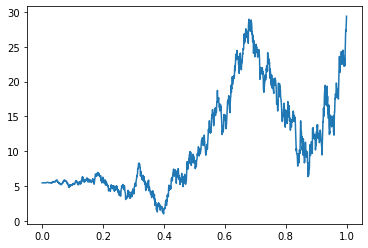

In [12]:
time_range = 1460 #in days
walk = brownian(time_range)
time = walk[0]
stock_price = walk[1] + np.abs(min(walk[1])) +1
plt.plot(time, stock_price)

Next, we define the exercise price, where here we choose a "smooth" deviation from the original stock price, essentially taking a stable function and adding noise, defined by a uniform distribution over an arbitrary, probably non-realistic range. Likewise, the interest rate should float between 0% and 1%, and finally the range of the time to expiration was made 1, 2, 3, 4, and 5 months.

In [13]:
variance=np.random.uniform(0.005, 0.01)
exercise_price = stock_price + 0.1*stock_price
interest = np.random.uniform(0.005,0.01, time_range)
expiration_date = 30 #days
volatility = 0.23

Finally, we can initialize the Model class, using the above as inputs and executing the call and put functions.

In [14]:
option = Model(stock_price, exercise_price, interest, expiration_date, volatility)
option.call()
option.put()

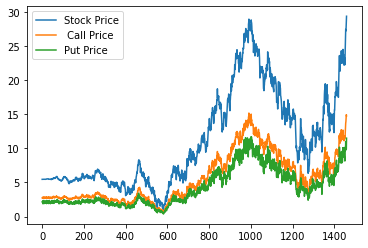

In [15]:
plt.plot(stock_price)
plt.plot(option.callval)
plt.plot(option.putval)
plt.legend(['Stock Price', ' Call Price', 'Put Price'])
plt.savefig('example.png')
plt.show()

Since we see that the behaviour is as expected and since we want to reuse the names of variables, we clear everything and move to Section 2. (We could just skip this step since the variables would simply get replaced, but it is easier during working to just clear everything. There were many instances where we unknowingly used variables that we didn't replace and were puzzled at the plots no changing etc.)

In [16]:
del option, stock_price, exercise_price, interest, variance, volatility, walk, time_range, time, expiration_date

### Section 2

#### Application using real-world data

Having checked that the idea works, we begin by opening the .xlsx file we wish to use and defining our parameters before initializing our class.

In [17]:
df = pd.read_excel('ZNGA.xlsx', usecols=['Date', 'High (in $)', 'Low (in $)', 'Close/Last', 'Difference of High and Low'])
high = df['High (in $)'].array
low = df['Low (in $)'].array
close = df['Close/Last'].array
date = df.Date.array
interest = np.random.uniform(0.005,0.01, len(close))
volatility = (np.average(high - low, weights = close))
expiration_date = 60

Because we want to check what happens for an exercise price both higher and lower than the original stock price (say ±10%), we create a vector containing those two values and we initialize both instances with a simple forloop

In [18]:
exercise_price = [close-(0.1*close), close+(0.1*close)]
option = []
for change in exercise_price:
    option.append(Model(close, change, interest, expiration_date, volatility))

Now we call the call() and put() functions for each of the instances to generate the data, which we have plotted below.

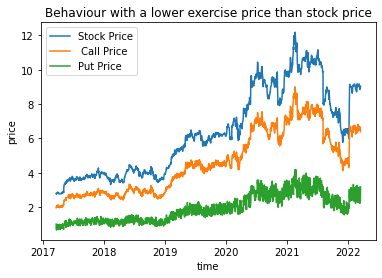

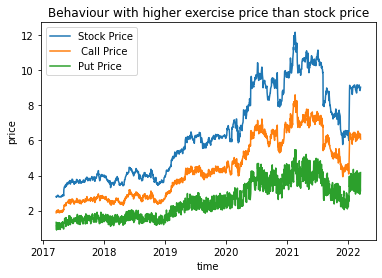

In [19]:
for model in option:
    model.call()
    model.put()
    
    plt.plot(date, close)
    plt.plot(date, model.callval)
    plt.plot(date, model.putval)
    plt.legend(['Stock Price', ' Call Price', 'Put Price'])
    plt.xlabel('time')
    plt.ylabel('price')
    
    if model.ex_p[0] < model.stock_p[0]:
        plt.title('Behaviour with a lower exercise price than stock price')
        plt.savefig('lower.png')
    else:
        plt.title('Behaviour with higher exercise price than stock price')
        plt.savefig('higher.png')
    
    plt.show()

Finally, we use pandas to export all of the information we have gathered and created into an excel file. The model genrates the data frame of values of change in option prices which can be converted into an xlsx file which can then be
passed onto/be communicated to a non python user for further interpretation and decision making.

In [20]:
data = []
for i in np.arange(len(exercise_price)):
        dict = {'Date': date,
        'Stock Price': option[i].stock_p,
        'Exercise Price': option[i].ex_p,
        'Interest': option[i].int_rate,
        'Time to Expiration': option[i].time_to_exp,
        'Volatility': option[i].vol,
        'Call Price': option[i].callval,
        'Put Price': option[i].putval}
        data.append(pd.DataFrame(dict, index = None))
        
with pd.ExcelWriter('assignment.xlsx') as writer:  
    data[0].to_excel(writer, sheet_name='Sheet 1', header = True, index = False)
    data[1].to_excel(writer, sheet_name='Sheet 2', header = True, index = False)